# Importing Images with Keras

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pathlib
from sklearn.model_selection import train_test_split

In [3]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [4]:
import IPython.display as display
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os

In [5]:
# checking Tensorflow version
tf.__version__

'2.2.0'

In [6]:
data_dir = pathlib.Path('./images/train/')

In [7]:
data_dir

PosixPath('images/train')

In [8]:
image_count = len(list(data_dir.glob('*/*.jpg')))
image_count

4713

In [9]:
images = list(data_dir.glob('*/*.jpg'))

In [10]:
CLASS_NAMES = np.array(['healthy', 'pneumonia', 'covid'])
CLASS_NAMES

array(['healthy', 'pneumonia', 'covid'], dtype='<U9')

In [11]:
healthy = list(data_dir.glob('*healthy/*.jpg'))
pneumonia = list(data_dir.glob('*pneumonia/*.jpg'))
covid = list(data_dir.glob('*covid/*.jpg'))

In [12]:
len(healthy) + len(pneumonia) + len(covid)

4713

In [13]:
print(f'healthy lungs: {len(healthy)} images')
print(f'pneumonia lungs: {len(pneumonia)} images')
print(f'coivd lungs: {len(covid)} images')

healthy lungs: 1573 images
pneumonia lungs: 2979 images
coivd lungs: 161 images


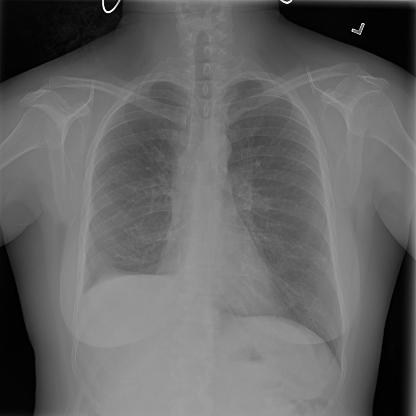

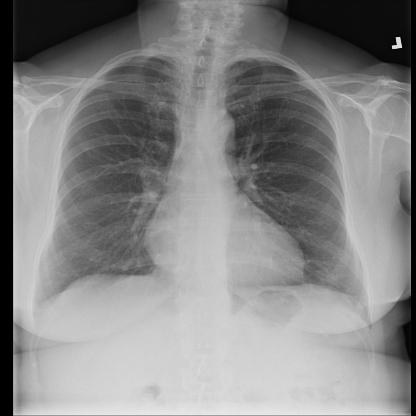

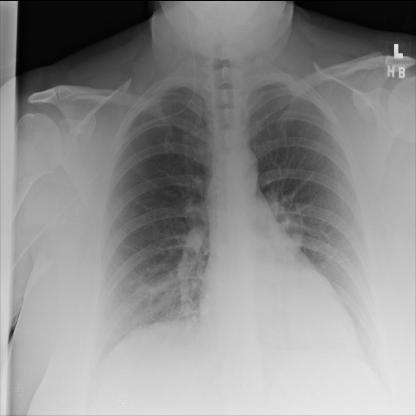

In [14]:
for image_path in healthy[3:6]:
    display.display(Image.open(str(image_path)))


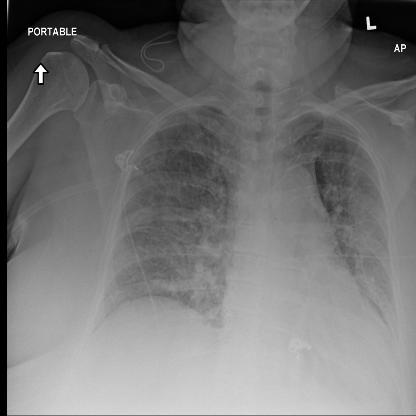

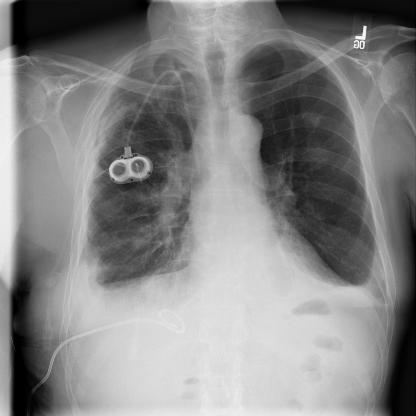

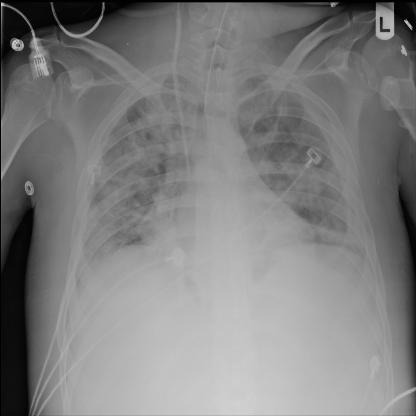

In [15]:
for image_path in pneumonia[15:18]:
    display.display(Image.open(str(image_path)))

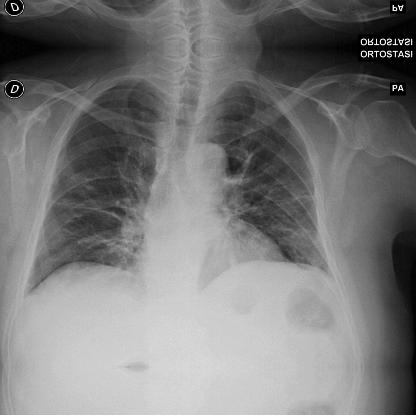

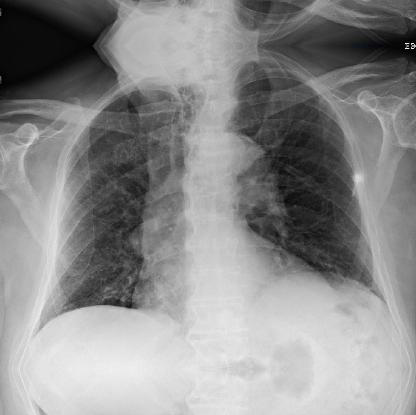

In [16]:
for image_path in covid[19:21]:
    display.display(Image.open(str(image_path)))

# Load using Keras

In [16]:
# The 1./255 is to convert from uint8 to float32 in range [0,1].
random_state = 42
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255, validation_split=0.2)

In [17]:
BATCH_SIZE = 32
IMG_HEIGHT = 224
IMG_WIDTH = 224
STEPS_PER_EPOCH = np.ceil(image_count/BATCH_SIZE)

In [18]:
train_data_gen = image_generator.flow_from_directory(directory=str(data_dir),
                                                     batch_size=BATCH_SIZE,
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     classes = list(CLASS_NAMES),
                                                     subset='training')
val_data_gen = image_generator.flow_from_directory(directory=str(data_dir),
                                                     batch_size=BATCH_SIZE,
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     classes = list(CLASS_NAMES),
                                                     subset='validation')

Found 4711 images belonging to 3 classes.
Found 1176 images belonging to 3 classes.


In [19]:
4711 + 1176

5887

In [24]:
def show_batch(image_batch, label_batch):
  plt.figure(figsize=(10,10))
  for n in range(25):
      ax = plt.subplot(5,5,n+1)
      plt.imshow(image_batch[n])
      plt.title(CLASS_NAMES[label_batch[n]==1][0].title())
      plt.axis('off')

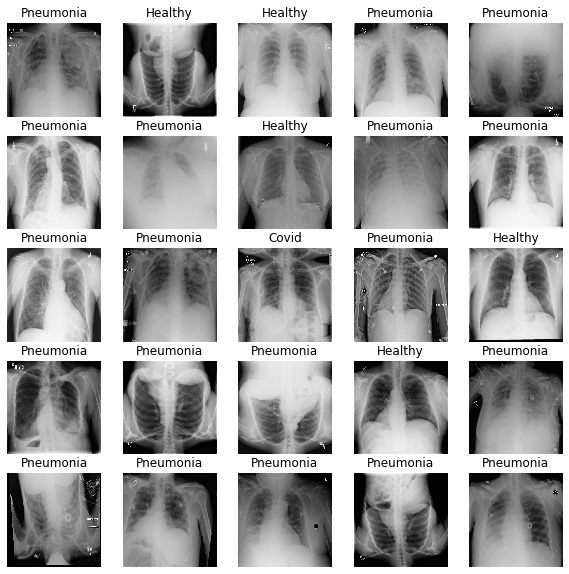

In [25]:
image_batch, label_batch = next(train_data_gen)
show_batch(image_batch, label_batch)

# MobileNet V2 model

In [26]:
# Initiate model
IMG_SHAPE = (IMG_WIDTH, IMG_HEIGHT, 3)

# Create the base model from the pre-trained model MobileNet V2
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [27]:
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 7, 7, 1280)


In [28]:
# Freeze the convolutional base
base_model.trainable = False

In [29]:
# Base model architecture
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
_______________________________________________________________________________

In [30]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [31]:
prediction_layer = tf.keras.layers.Dense(3)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 3)


In [32]:
model = tf.keras.Sequential([
  base_model,
  global_average_layer,
  prediction_layer
])

In [33]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [34]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 3)                 3843      
Total params: 2,261,827
Trainable params: 3,843
Non-trainable params: 2,257,984
_________________________________________________________________


In [35]:
len(model.trainable_variables)

2

In [36]:
initial_epochs = 10
validation_steps =20

loss0,accuracy0 = model.evaluate(val_data_gen, steps = validation_steps)

20/20 [==============================] - 20s 1s/step - loss: 0.8398 - accuracy: 0.3063


In [37]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.84
initial accuracy: 0.31


In [38]:
history = model.fit(train_data_gen,
                    epochs=initial_epochs,
                    validation_data=val_data_gen)

Epoch 1/10
148/148 [==============================] - 250s 2s/step - loss: 0.5073 - accuracy: 0.6079 - val_loss: 0.4127 - val_accuracy: 0.7228
Epoch 2/10
148/148 [==============================] - 194s 1s/step - loss: 0.3881 - accuracy: 0.7499 - val_loss: 0.3612 - val_accuracy: 0.7730
Epoch 3/10
148/148 [==============================] - 194s 1s/step - loss: 0.3512 - accuracy: 0.7786 - val_loss: 0.3373 - val_accuracy: 0.7866
Epoch 4/10
148/148 [==============================] - 194s 1s/step - loss: 0.3323 - accuracy: 0.7888 - val_loss: 0.3249 - val_accuracy: 0.7891
Epoch 5/10
148/148 [==============================] - 195s 1s/step - loss: 0.3202 - accuracy: 0.7977 - val_loss: 0.3205 - val_accuracy: 0.7900
Epoch 6/10
148/148 [==============================] - 195s 1s/step - loss: 0.3114 - accuracy: 0.8011 - val_loss: 0.3120 - val_accuracy: 0.7900
Epoch 7/10
148/148 [==============================] - 195s 1s/step - loss: 0.3051 - accuracy: 0.8045 - val_loss: 0.3076 - val_accuracy: 0.7908

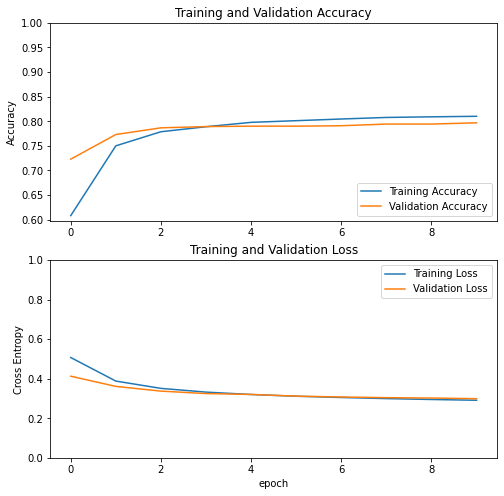

In [39]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [40]:
base_model.trainable = True

In [41]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  155


In [42]:
# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

In [43]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(lr=base_learning_rate/10),
              metrics=['accuracy'])

In [44]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 3)                 3843      
Total params: 2,261,827
Trainable params: 1,866,435
Non-trainable params: 395,392
_________________________________________________________________


In [45]:
len(model.trainable_variables)

58

In [49]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_data_gen,
                         epochs = total_epochs,
                         initial_epoch =  history.epoch[-1],
                         validation_data = val_data_gen)

Epoch 10/20
148/148 [==============================] - 304s 2s/step - loss: 0.4009 - accuracy: 0.7533 - val_loss: 0.3196 - val_accuracy: 0.7942
Epoch 11/20
148/148 [==============================] - 301s 2s/step - loss: 0.2920 - accuracy: 0.8168 - val_loss: 0.3110 - val_accuracy: 0.8010
Epoch 12/20
148/148 [==============================] - 302s 2s/step - loss: 0.2566 - accuracy: 0.8440 - val_loss: 0.3050 - val_accuracy: 0.8070
Epoch 13/20
148/148 [==============================] - 300s 2s/step - loss: 0.2306 - accuracy: 0.8559 - val_loss: 0.3050 - val_accuracy: 0.8112
Epoch 14/20
148/148 [==============================] - 301s 2s/step - loss: 0.2084 - accuracy: 0.8726 - val_loss: 0.3024 - val_accuracy: 0.8163
Epoch 15/20
148/148 [==============================] - 347s 2s/step - loss: 0.1908 - accuracy: 0.8881 - val_loss: 0.3013 - val_accuracy: 0.8180
Epoch 16/20
148/148 [==============================] - 301s 2s/step - loss: 0.1684 - accuracy: 0.9021 - val_loss: 0.3083 - val_accuracy:

In [53]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

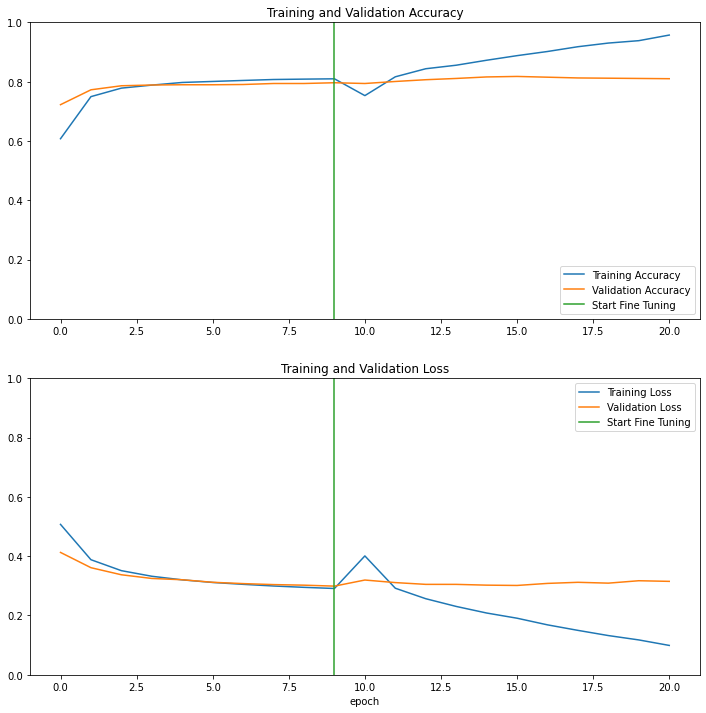

In [54]:
plt.figure(figsize=(12, 12))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

# KERAS WITH AUGMENTED IMAGES

In [38]:
# The 1./255 is to convert from uint8 to float32 in range [0,1].
random_state = 42
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255, validation_split=0.2, zca_whitening = True, horizontal_flip = True, vertical_flip = True )

In [39]:
1176/(1176+4711)

0.19976218787158145

In [40]:
BATCH_SIZE = 32
IMG_HEIGHT = 224
IMG_WIDTH = 224

In [41]:
data_dir

PosixPath('images/train')

In [42]:
train_data_gen = image_generator.flow_from_directory(directory=str(data_dir),
                                                     batch_size=BATCH_SIZE,
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     classes = list(CLASS_NAMES),
                                                     subset='training')
val_data_gen = image_generator.flow_from_directory(directory=str(data_dir),
                                                     batch_size=BATCH_SIZE,
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     classes = list(CLASS_NAMES),
                                                     subset='validation')

Found 3772 images belonging to 3 classes.
Found 941 images belonging to 3 classes.


In [43]:
def show_batch(image_batch, label_batch):
  plt.figure(figsize=(10,10))
  for n in range(25):
      ax = plt.subplot(5,5,n+1)
      plt.imshow(image_batch[n])
      plt.title(CLASS_NAMES[label_batch[n]==1][0].title())
      plt.axis('off')

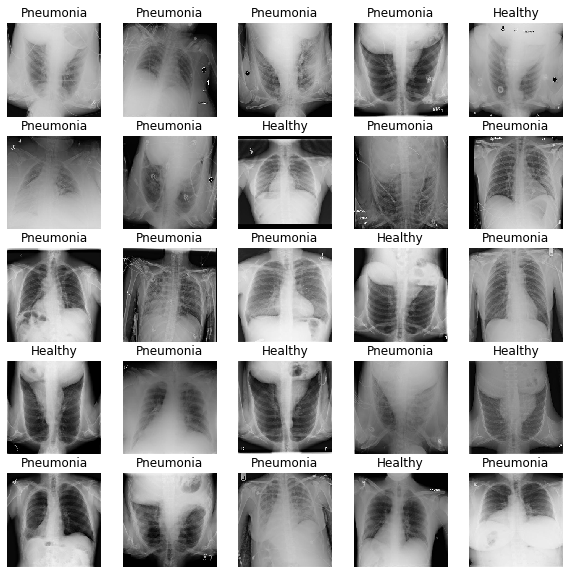

In [44]:
image_batch, label_batch = next(train_data_gen)
show_batch(image_batch, label_batch)

In [45]:
# Initiate model
IMG_SHAPE = (IMG_WIDTH, IMG_HEIGHT, 3)

# Create the base model from the pre-trained model MobileNet V2
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [46]:
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 7, 7, 1280)


In [47]:
# Freeze the convolutional base
base_model.trainable = False

In [48]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [49]:
prediction_layer = tf.keras.layers.Dense(3)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 3)


In [50]:
model = tf.keras.Sequential([
  base_model,
  global_average_layer,
  prediction_layer
])

In [51]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [52]:
initial_epochs = 10
validation_steps =20

loss0,accuracy0 = model.evaluate(val_data_gen, steps = validation_steps)

20/20 [==============================] - 21s 1s/step - loss: 2.5560 - accuracy: 0.0453


In [53]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 2.56
initial accuracy: 0.05


In [54]:
history = model.fit(train_data_gen,
                    epochs=initial_epochs,
                    validation_data=val_data_gen)

Epoch 1/10
118/118 [==============================] - 186s 2s/step - loss: 1.0860 - accuracy: 0.4952 - val_loss: 0.7351 - val_accuracy: 0.6695
Epoch 2/10
118/118 [==============================] - 196s 2s/step - loss: 0.6816 - accuracy: 0.6999 - val_loss: 0.6448 - val_accuracy: 0.7163
Epoch 3/10
118/118 [==============================] - 186s 2s/step - loss: 0.6228 - accuracy: 0.7359 - val_loss: 0.5782 - val_accuracy: 0.7566
Epoch 4/10
118/118 [==============================] - 221s 2s/step - loss: 0.5825 - accuracy: 0.7545 - val_loss: 0.5587 - val_accuracy: 0.7588
Epoch 5/10
118/118 [==============================] - 200s 2s/step - loss: 0.5624 - accuracy: 0.7630 - val_loss: 0.5590 - val_accuracy: 0.7545
Epoch 6/10
118/118 [==============================] - 204s 2s/step - loss: 0.5455 - accuracy: 0.7709 - val_loss: 0.5347 - val_accuracy: 0.7662
Epoch 7/10
118/118 [==============================] - 202s 2s/step - loss: 0.5348 - accuracy: 0.7747 - val_loss: 0.5214 - val_accuracy: 0.7694